# Amazon, EDA

## Importar

In [1]:
# %load basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',200)
pd.options.display.float_format = '{:.2f}'.format
liga = '/home/ef/Documents/Diplomado/Amazon/data/csv/'

In [2]:
import time
start = time.time()

In [3]:
import os
os.listdir(liga)

['video_games.csv',
 'images',
 'kindle_store.csv',
 'movies_and_tv.csv',
 'cell_phones_and_accessories.csv']

In [4]:
df = pd.DataFrame()
#Consolidar tablas en una
for x in [f for f in os.listdir(liga) if f.endswith('.csv')]:
    df = df.append(pd.read_csv(liga + x, low_memory = False), ignore_index = True)
    
df.sample(4)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,category
594326,5.00,True,"07 2, 2012",A3EOHJ6IV8548X,B004WOBMIE,LGTT,I purchased a samsung droid phone last year an...,Verizon Samsung Droid Charge desktop docking s...,1341187200,NaN,NaN,NaN,cell_phones_and_accessories
541079,5.00,True,"02 28, 2016",ATHEZP7OA2GK0,6301966554,Dr. C,Classic,Five Stars,1456617600,NaN,{'Format:': ' Amazon Video'},NaN,movies_and_tv
575088,5.00,True,"12 5, 2010",A2OWOGH06B60WB,B0041U2D7I,J. Mendez,I am SO satisfied with my purchase of this cas...,GREAT CASE & STAND,1291507200,3,{'Color:': ' Purple'},NaN,cell_phones_and_accessories
481354,4.00,True,"06 20, 2015",AV43XTELD8RQA,6300247821,Angela Martin,Ever since the first time I watched this movie...,Wonderful,1434758400,NaN,{'Format:': ' DVD'},NaN,movies_and_tv


## Funciones

In [5]:
import math
#Tiempo en minutos y segundos
def time_exp(x):
    print(str(int(math.floor(x/60))
             ) + " minutos con " + '{:.2f}'.format(60*(x/60 - math.floor(x/60))
                                                  ) + " segundos")

In [6]:
def fechas(df, col, formato = "%m %d, %Y"):
    df = df.copy()
    df[col] = pd.to_datetime(df[col], format = formato)
    df['Anio'] = df[col].dt.year
    meses = ['ene','feb','mar','abr','may','jun',
             'jul','ago','sep','oct','nov','dic']
    meses = dict(zip(range(1,13),meses))
    #Mes en formato MMM (español)
    df['Mes'] = df[col].dt.month.replace(meses)
    df['Sem'] = df[col].dt.isocalendar().week
    diasem = ['lun','mar','mie','jue','vie','sab','dom']
    diasem = dict(zip(range(7),diasem))
    #Día de la semana en formato DDD
    df['DiaSem'] = df[col].dt.dayofweek.replace(diasem)
    display(df['Anio'].hist())
    return df, meses, diasem

In [103]:
'''
#Activar si es la primera vez que se ocupan stopwords o Lemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
'''
import re
import unicodedata
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lem = WordNetLemmatizer()

def clean_text(text,language = 'english',
               add_stopwords = [], 
               pattern ='[^a-zA-Z]'):
    cleaned_text = unicodedata.normalize('NFD', str(text)).encode('ascii', 'ignore')
    cleaned_text = re.sub(pattern, ' ', 
                          cleaned_text.decode('utf-8'), 
                          flags = re.UNICODE)
    cleaned_text = ' '.join([lem.lemmatize(word) for word in 
                             cleaned_text.lower().split() if word not in 
                             stopwords.words(language) + add_stopwords])
    return cleaned_text

In [145]:
from nltk import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def sentiment(text):
    sid = SentimentIntensityAnalyzer()
    try:
        list(map(sid.polarity_scores,sent_tokenize(text)))[0]
    except:
        sentences = sent_tokenize('a')
    else:
        sentences = sent_tokenize(text)
    res = map(sid.polarity_scores, sentences)
    return list(res)[0]

## EDA

### Fechas

<AxesSubplot:>

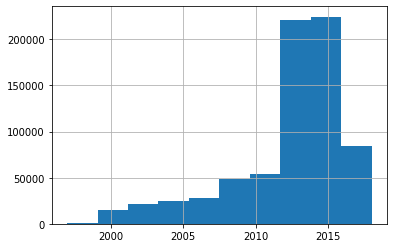

In [9]:
df, meses, diasem = fechas(df,'reviewTime')

In [10]:
from datetime import datetime

df['unixReviewTime'] = [datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d') for ts in df['unixReviewTime']] 
df['unixReviewTime'] = pd.to_datetime(df['unixReviewTime'])
df['unixReviewTime'] -= df['reviewTime']
#No hay diferencia entre reviewTime y unixReviewTime
df['unixReviewTime'].value_counts(1)

0 days   1.00
Name: unixReviewTime, dtype: float64

### Style

In [11]:
df['style'].value_counts(1, dropna = False)

NaN                                                               0.29
{'Format:': ' Kindle Edition'}                                    0.23
{'Format:': ' DVD'}                                               0.13
{'Format:': ' Amazon Video'}                                      0.07
{'Format:': ' Video Game'}                                        0.06
                                                                  ... 
{'Color:': ' Blue TPU', 'Package Type:': ' Standard Packaging'}   0.00
{'Size:': ' 3.5inch', 'Color:': ' Black'}                         0.00
{'Size:': ' Samsung Galaxy Note 3', 'Color:': ' Hot Pink'}        0.00
{'Color:': ' S580 - 5 inch'}                                      0.00
{'Color:': ' Minnie Red'}                                         0.00
Name: style, Length: 3447, dtype: float64

In [12]:
#Se intentará evaluar cada registro
aux = []
for x in df['style']:
    try:
        #Dado que es un string que representa un diccionario
        eval(x)
    except:
        #En caso de encontrar nulos, crear un diccionario arbitrario
        aux.append({'Vacio':'Sí'})
    else:
        aux.append(eval(x))

#Lista de diccionarios se convierte a DataFrame
aux = pd.DataFrame(aux)
aux.sample(4)

,Vacio,Format:,Platform:,Edition:,Color:,Size:,Style:,Length:,Subscription Length:,Content:,Package Type:,Package Quantity:,Model:,Offer Type:,Product Packaging:,Style Name:,Size Name:,Color Name:,Pattern:
390485,NaN,DVD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
622164,Sí,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
305544,NaN,Kindle Edition,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
499126,Sí,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
#Son columnas poco pobladas, se procede a omitirlas, con excepción de la primera
for col in aux.columns:
    display(aux[col].value_counts(1,dropna = False).reset_index())

,index,Vacio
0,NaN,0.71
1,Sí,0.29


,index,Format:
0,NaN,0.46
1,Kindle Edition,0.23
2,DVD,0.13
3,Amazon Video,0.07
4,Video Game,0.06
5,Blu-ray,0.02
6,VHS Tape,0.02
7,Paperback,0.00
8,DVD-ROM,0.00
9,Computer Game,0.00


,index,Platform:
0,NaN,0.95
1,PC,0.01
2,Xbox 360,0.01
3,PlayStation 3,0.01
4,PlayStation2,0.01
5,Nintendo Wii,0.00
6,Xbox,0.00
7,Nintendo DS,0.00
8,GameCube,0.00
9,Sony PSP,0.00


,index,Edition:
0,NaN,0.98
1,Standard,0.01
2,Game only,0.00
3,Game of the Year,0.00
4,Collector's,0.00
...,...,...
83,Akuma,0.00
84,Includes Gift with Purchase,0.00
85,"8,000 mAh",0.00
86,Wired bundle (2 guitars),0.00


,index,Color:
0,NaN,0.90
1,Black,0.03
2,White,0.01
3,black,0.01
4,Clear,0.00
...,...,...
1990,Smoke Hexagon,0.00
1991,White/ Gray,0.00
1992,Pink on Black,0.00
1993,Digital Camo Green/Black,0.00


,index,Size:
0,NaN,0.97
1,One Size,0.00
2,Value not found,0.00
3,.!Only Bluetooth 2.0,0.00
4,iphone 4/4S,0.00
...,...,...
515,60 ft,0.00
516,Samsung Galaxy Note N7000 + Battery,0.00
517,BodySuit,0.00
518,1,0.00


,index,Style:
0,NaN,1.00
1,Standard Version,0.00
2,Standard Edition,0.00
3,other,0.00
4,Standard Whip (7.5 in),0.00
5,Long Whip (14.5 in),0.00
6,3-Pack,0.00
7,Peak 6000,0.00
8,PlayStation 2,0.00
9,Lifetime Maps,0.00


,index,Length:
0,NaN,1.00
1,1600 Points,0.00
2,4000 Points,0.00
3,400 Points,0.00
4,800 Points,0.00
5,1200 Points,0.00
6,2400 Points,0.00
7,2000 Points,0.00
8,1000 Points,0.00
9,2800 Points,0.00


,index,Subscription Length:
0,NaN,1.00
1,1600 Points,0.00
2,4000 Points,0.00
3,400 Points,0.00
4,800 Points,0.00
5,1200 Points,0.00
6,2400 Points,0.00
7,2000 Points,0.00
8,1000 Points,0.00
9,2800 Points,0.00


,index,Content:
0,NaN,1.00
1,4000 Points,0.00
2,1200 Points,0.00
3,800 Points,0.00
4,2400 Points,0.00
5,400 Points,0.00
6,1600 Points,0.00
7,2000 Points,0.00
8,3600 Points,0.00
9,2800 Points,0.00


,index,Package Type:
0,NaN,0.95
1,Standard Packaging,0.04
2,Frustration-Free Packaging,0.00
3,Bundle with Headset,0.00


,index,Package Quantity:
0,NaN,1.00
1,1,0.00


,index,Model:
0,NaN,1.00
1,7-Port,0.00
2,Nuvi 200,0.00


,index,Offer Type:
0,NaN,1.00
1,GH11720A/EH64AVFWE,0.00
2,MCUP,0.00
3,Classic,0.00
4,Standard Smartphone,0.00
...,...,...
129,BlackBerry,0.00
130,Case for LG Sentio GS505,0.00
131,Cable & Adapter,0.00
132,MCUPPRO,0.00


,index,Product Packaging:
0,NaN,1.00
1,Standard Packaging,0.00
2,Motorola Retail Packaging,0.00
3,Frustration-Free Packaging,0.00


,index,Style Name:
0,NaN,1.00
1,USB Charger,0.00
2,12V Sockets,0.00
3,"All Phones Up to 6""l X 2.9""w X 0.625""d",0.00
4,"All Phones Up to 7.8""l X 3.5""w X 0.5""d",0.00
5,for iPad/Tablet,0.00
6,"All Phones Up to 7.8""l X 3.7""w X 0.7""d",0.00
7,Nate Doss Buzz Mid-Range Driver,0.00
8,Modern,0.00
9,Monitors,0.00


,index,Size Name:
0,NaN,1.00
1,6000MAH,0.00
2,55 inch extra,0.00
3,55 inch,0.00
4,49-50 inch,0.00
5,58-60 inch,0.00


,index,Color Name:
0,NaN,1.00
1,Black,0.00


,index,Pattern:
0,NaN,1.00
1,Crack without Certified,0.00


In [14]:
df['style'] = aux.iloc[:,:1].fillna('No_especifica')
df['style'].value_counts(1, dropna = False)

No_especifica   0.71
Sí              0.29
Name: style, dtype: float64

### Images

In [15]:
eval(df[df['image'].notnull()]['image'].reset_index(drop = True)[22])[0]

'https://images-na.ssl-images-amazon.com/images/I/717Z74YEuIL._SY88.jpg'

In [16]:
#Se guarda el dataset con link de imágenes para trabajarlo en el módulo IV
image_dataset = df[df['image'].notnull()].copy()
image_dataset['image'] = list(map(lambda x:eval(x)[0],image_dataset['image']))
image_dataset.to_csv(liga + 'images/image_dataset.csv', index = False)

In [17]:
df = df[df['image'].isnull()].reset_index(drop = True).copy()
len(df)

720018

### Review

In [18]:
df['reviewText'] += " " + df['summary']

In [19]:
import concurrent.futures

texto = 'reviewText'
with concurrent.futures.ProcessPoolExecutor() as executor:
    limpio = list(executor.map(clean_text, df[texto]))

df[f'{texto}_limpio'] = list(map(lambda x:str(x),limpio))
df[f'{texto}_long'] = df[texto].str.len()
df[f'{texto}_n_words'] = df[texto].str.split().str.len()
df[f'{texto}_relevant'] = (df[f'{texto}_limpio'].str.len()+1) / (df[texto].str.len()+1)

df[[texto,f'{texto}_limpio',f'{texto}_long',
    f'{texto}_n_words',f'{texto}_relevant']].sample(7)

,reviewText,reviewText_limpio,reviewText_long,reviewText_n_words,reviewText_relevant
54006,This is a great game for someone that doesn't ...,great game someone like play long period time ...,251.00,51.00,0.57
304640,Maybe I should be glad I didn't discover the W...,maybe glad discover witchlight trilogy written...,409.00,74.00,0.59
305261,Loved this book. I have a yorkie too so could...,loved book yorkie could relate thing little on...,104.00,21.00,0.55
28591,I was very impressed by this game...and I like...,impressed game liked original one anyway usual...,775.00,141.00,0.61
358997,Your Free EBooks are WONDERFUL ****** THANK YO...,free ebooks wonderful thank keep good work im ...,157.00,30.00,0.57
599548,Did I get your attention? I hope I did because...,get attention hope wonderful piece advice save...,1012.00,194.00,0.62
410884,I love this movie. It's about Bronco Billy (as...,love movie bronco billy portrayed eastwood bos...,932.00,167.00,0.60


In [ ]:
df.to_csv(liga[:-4] + 'df.csv', index = False)

In [149]:
import concurrent.futures

texto = 'reviewText_limpio'
with concurrent.futures.ProcessPoolExecutor() as executor:
    sentim = pd.DataFrame(list(executor.map(sentiment,
                                            df[texto])))
sentim.sample(4)

,neg,neu,pos,compound
62442,0.18,0.52,0.30,0.95
332435,0.04,0.62,0.34,0.95
337888,0.03,0.65,0.32,0.95
451408,0.39,0.55,0.06,-0.95


In [162]:
sentim.to_csv(liga[:-4] + 'sentim.csv', index = False)

In [156]:
df = df.join(sentim)

In [157]:
df.drop(columns = ['reviewerID','asin','reviewerName',
                   'unixReviewTime','vote', 'image'],
        inplace = True)
df.sample(4)

,overall,verified,reviewTime,reviewText,summary,style,category,Anio,Mes,Sem,DiaSem,reviewText_limpio,reviewText_long,reviewText_n_words,reviewText_relevant,neg,neu,pos,compound
432923,5.00,False,2013-06-21,Awesome movie! Recommend for everyone to reali...,Great Flick,No_especifica,movies_and_tv,2013,jun,25,vie,awesome movie recommend everyone realize true ...,148.00,25.00,0.68,0.00,0.29,0.70,0.96
378606,5.00,True,2016-02-05,I Loved it! Five Stars,Five Stars,No_especifica,movies_and_tv,2016,feb,5,vie,loved five star,22.00,5.00,0.70,0.00,0.34,0.66,0.60
562633,2.00,True,2010-12-02,You have to take your iphone out of the case t...,Not what I expected,Sí,cell_phones_and_accessories,2010,dic,48,jue,take iphone case fit speaker speaker damper so...,195.00,37.00,0.55,0.00,0.62,0.38,0.80
414635,5.00,True,2015-07-30,Still enjoying a few episodes per week! Great...,Still Five Stars from me!,No_especifica,movies_and_tv,2015,jul,31,jue,still enjoying episode per week great acting c...,106.00,17.00,0.78,0.00,0.57,0.43,0.82


In [163]:
df.dropna().to_csv(liga[:-4] + 'df_sentim.csv', index = False)

## Fin

In [159]:
#Tiempo total para correr el notebook
end = time.time()
time_exp(end - start)

474 minutos con 29.48 segundos


In [152]:
#Tono para cuando termina el script
from IPython.lib.display import Audio
import numpy as np

framerate = 4410
play_time_seconds = 1

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(5*np.pi*300*t) + np.sin(2*np.pi*240*t)

#La siguiente línea suena!
Audio(audio_data, rate=framerate, autoplay=True)